## Using LSTM model to predict disconnections
- Uses single window
- Only output in the final stage
- Predicting 24 seconds before disconnection

In [68]:
import IPython
import sys
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import tensorflow as tf
import os
import matplotlib as mp
import matplotlib.pyplot as plt
import pandas as pd 

from tensorflow.keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical



In [196]:
#populates the labels
def populateLabel(labels, Tx, indent = 8):
	indices = np.argwhere(labels == 0).flatten()
	for i in indices:
		labels[i-indent:i] = 0
	
	return list(indices)

# generate the dataset and return X and y inputs
def generateDataset(dataset, Tx, nx):
	labels = dataset['Connected'].to_numpy()
	dataset = dataset[['linkQuality','neighborLinkQuality', 'AVG RSSI value']]
	dt = dataset.to_numpy()

	print(dt.shape)
	indices = populateLabel(labels, Tx, indent = 12)
	# dt = np.delete(dt, indices, axis=0)
	# labels = np.delete(labels, indices, axis=0)	
	print(dt.shape)


	entry, param = dt.shape
	X = np.zeros((entry, Tx, nx))
	y = np.zeros((Tx, entry, 1))
	labels = np.reshape(labels, (entry,1))

	label_idx = 0
	x_idx = 0
	data_size = 0
	print(indices)
	for i in range(entry):		
		dt_idx = [x+x_idx for x in range(Tx)]
		if dt_idx.__contains__(indices[label_idx]):
			x_idx = indices[label_idx] + 1
			label_idx += 1
		# print(x_idx, x_idx + Tx)
		if entry <= x_idx:
			break	
		X[i, :, :] = dt[x_idx : x_idx + Tx, :]
		y[:, i, :] = labels[x_idx: x_idx + Tx, :]
		data_size = i	
		x_idx += 1
		
	print(data_size)

	# m = int(entry / Tx)
	# cnt = Tx
	# X = np.zeros((m, Tx, nx))
	# y = np.zeros((Tx, m, 1))
	# labels = np.reshape(labels, (entry,1))
	# for i in range(m):
	# 	s_idx = i*Tx		
	# 	if s_idx + Tx > entry:
	# 		cnt = entry
	# 	else:
	# 		cnt = s_idx + Tx
	# 	X[i, :, :] = dt[s_idx : cnt, :]
	# 	y[:, i, :] = labels[s_idx : cnt, :]
	# 	#print(s_idx, entry, cnt)
	# 	#print(dt[s_idx : cnt, :])

	return X, y, data_size + 1

In [284]:
Tx = 16
nx = 3
data = pd.read_csv("dataset/win32_dataset.csv")
#print(data.columns)

data['RSSI value'] = (data['RSSI value'] - data['RSSI value'].mean()) / data['RSSI value'].std()
data['AVG RSSI value'] = (data['AVG RSSI value'] - data['AVG RSSI value'].mean()) / data['AVG RSSI value'].std()

dataset = data[['linkQuality','neighborLinkQuality', 'AVG RSSI value', 'Connected']]
#dataset.head(5)


In [285]:
X, y, data_size = generateDataset(dataset, Tx, nx)

X = X[:data_size,:,:]
y = y[:,:data_size]

# working with y prediction at the end of the file
print(y.shape)
y = y[15, :data_size]
#y = np.transpose(y, (1, 0))
print(y.shape)

entry = X.shape[0]

train_size = round(0.8*entry)
trainX, trainy = X[0:train_size,:,:], y[:train_size,:]
testX, testy = X[train_size:,:,:], y[train_size:,:]
print(trainX.shape, testX.shape)
print(trainy.shape, testy.shape)
#print(testy[1:3,:,:])
print()

(2178, 3)
(2178, 3)
[59, 118, 259, 400, 533, 664, 811, 959, 1110, 1257, 1322, 1384, 1447, 1510, 1679, 1846, 2012, 2177]
1889
(16, 1890, 1)
(1890, 1)
(1512, 16, 3) (378, 16, 3)
(1512, 1) (378, 1)



In [273]:
# print(X[1889,:,:])
# print(y[:,1888])

In [230]:
# number of dimensions for the hidden state of each LSTM cell.
n_a = 32
n_values = nx # number of parameters
reshaper = Reshape((1, n_values))      
LSTM_cell = LSTM(n_a, return_state = True)
densor = Dense(1, activation='sigmoid')

In [260]:
def connectionModel(Tx, LSTM_cell, densor, reshaper):
    """
    Implement the connection model composed of Tx LSTM cells where each cell is responsible
    for learning the following note based on the previous note and context.
    Each cell has the following schema:
            [X_{t}, a_{t-1}, c0_{t-1}] -> RESHAPE() -> LSTM() -> DENSE()
    Arguments:
        Tx -- length of the sequences in the corpus
        LSTM_cell -- LSTM layer instance
        densor -- Dense layer instance
        reshaper -- Reshape layer instance
    
    Returns:
        model -- a keras instance model with inputs [X, a0, c0]
    """
    # Get the shape of input values
    n_values = nx
    
    # Get the number of the hidden state vector
    n_a = LSTM_cell.units
    
    # Define the input layer and specify the shape
    X = Input(shape=(Tx, n_values)) 
    
    # Define the initial hidden state a0 and initial cell state c0
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    
	#empty list for the output
    outputs = []

    #Loop over tx
    for t in range(Tx):        
        #select the "t"th time step vector from X. 
        x = X[:,t,:]
        #print(x.shape)
        #Use reshaper to reshape x to be (1, n_values)
        x = reshaper(x)
        #Perform one step of the LSTM_cell
        a, _, c = LSTM_cell(x, initial_state=[a,c])
        #Apply densor to the hidden state output of LSTM_Cell
    out = densor(a)
    print(out.shape)
	
    #add the output to "outputs"    
    #outputs.append(op)
        
    #Create model instance
    model = Model(inputs=[X, a0, c0], outputs=out)
    return model

In [261]:
model = connectionModel(Tx, LSTM_cell=LSTM_cell, densor=densor, reshaper=reshaper)

(None, 1)


In [ ]:
model.summary()

In [262]:
opt = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [263]:
m = trainX.shape[0]
testSize = testX.shape[0]
a0 = np.zeros((m, n_a))
c0 = np.zeros((m, n_a))

In [264]:
print(trainy.shape)
trainy = np.transpose(trainy, (1, 0))
history = model.fit([trainX, a0, c0], trainy, epochs=95, verbose = 0)

(1, 1512)


loss at epoch 1: 0.24339276552200317
loss at epoch 100: 0.02920772135257721


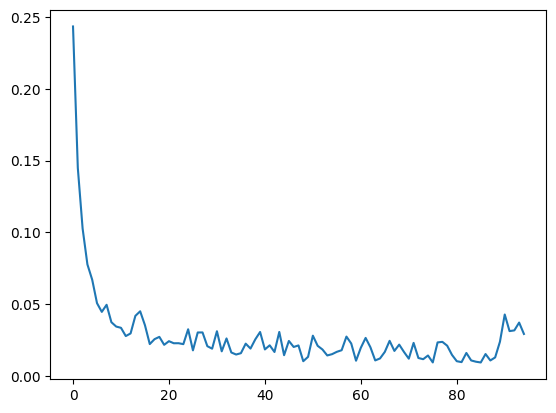

In [265]:
print(f"loss at epoch 1: {history.history['loss'][0]}")
print(f"loss at epoch 100: {history.history['loss'][94]}")
plt.plot(history.history['loss'])

In [43]:
def connection_inference_model(LSTM_cell, densor, Ty=Tx):
    """
    Uses the trained "LSTM_cell" and "densor" from model() to generate a sequence of values.
    
    Arguments:
    LSTM_cell -- the trained "LSTM_cell" from model(), Keras layer object
    densor -- the trained "densor" from model(), Keras layer object
    Ty -- integer, number of time steps to generate
    
    Returns:
    inference_model -- Keras model instance
    """
    
    # Get the shape of input values hello
    n_values = nx
    # Get the number of the hidden state vector
    n_a = LSTM_cell.units
    
    # Define the input of your model with a shape 
    X = Input(shape=(Ty, n_values))
    
    
    # Define s0, initial hidden state for the decoder LSTM
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    
    outputs = []

    print(X.shape)

    for t in range(Ty):
        x = X[:,t,:]
        print(x.shape)
        x = reshaper(x)
        a, _, c = LSTM_cell(x, initial_state=[a,c])
        out = densor(a)
        outputs.append(out)
        print(x.shape)

    inference_model = Model(inputs=[X,a0,c0], outputs=outputs)    
    return inference_model

In [286]:
def calculate_accuracy(array1, array2):
    assert array1.shape == array2.shape, "Arrays must be of the same shape"
    correct = np.sum(np.equal(array1,array2))
    total = np.size(array1)
    return correct/total

# Trying it out on test set


In [287]:
testSize = testX.shape[0]
a_initializer = np.zeros((testSize, n_a))
c_initializer = np.zeros((testSize, n_a))

tst = testX
pred = model.predict([tst, a_initializer, c_initializer])

#analyse data
for i in range(len(pred)):
	pred[i] = [1 if x >= 0.5 else 0 for x in pred[i]]

ypred = np.array(pred)
ypred = ypred.reshape(testSize, 1)

print(calculate_accuracy(ypred, testy))


trainy_op =  ypred.astype('int')
print("hello", trainy_op.shape)
modeloutput = pd.DataFrame(trainy_op)
realoutput = pd.DataFrame(testy)
modeloutput.to_csv("modeloutput.csv")
realoutput.to_csv("real_output.csv")


12/12 [==============================] - 7s 7ms/step
0.9867724867724867
hello (378, 1)


# Accuracy on training set

In [288]:
#train set accuracy check
testSize = train_size
a_initializer = np.zeros((testSize, n_a))
c_initializer = np.zeros((testSize, n_a))

In [289]:

tst = trainX
print(tst.shape)
#inference_model = connection_inference_model(LSTM_cell, densor, Tx)
#pred = inference_model.predict([tst, a_initializer, c_initializer])
pred = model.predict([tst, a_initializer, c_initializer])

(1512, 16, 3)
48/48 [==============================] - 4s 9ms/step


In [290]:
for i in range(len(pred)):
	pred[i] = [1 if x >= 0.5 else 0 for x in pred[i]]


ypred = np.array(pred)
ypred = ypred.reshape(testSize, 1)

print(ypred.shape, trainy.shape)
print(calculate_accuracy(ypred, trainy))

trainy_op =  ypred.astype('int')
print("hello", trainy_op.shape)
modeloutput = pd.DataFrame(trainy_op)
realoutput = pd.DataFrame(trainy)
modeloutput.to_csv("modeloutputTrain.csv")
realoutput.to_csv("real_outputTrain.csv")


(1512, 1) (1512, 1)
0.9880952380952381
hello (1512, 1)


In [ ]:
# model.save('lstm_modlel')
# trainX[1275,:,:]

array([[ 1.        ,  1.        , -1.36616162],
       [ 1.        ,  0.886     , -1.4255813 ],
       [ 1.        ,  0.886     , -1.48500098],
       [ 1.        ,  0.886     , -1.48500098],
       [ 1.        ,  0.796     , -1.48500098],
       [ 1.        ,  0.796     , -1.54442066],
       [ 0.894     ,  0.689     , -1.54442066],
       [ 0.886     ,  0.689     , -1.54442066],
       [ 0.831     ,  0.541     , -1.60384035],
       [ 0.831     ,  0.541     , -1.54442066],
       [ 0.812     ,  0.541     , -1.54442066],
       [ 0.729     ,  0.541     , -1.54442066],
       [ 0.662     ,  0.329     , -1.54442066],
       [ 0.643     ,  0.329     , -1.54442066],
       [ 0.596     ,  0.329     , -1.54442066],
       [ 0.497     ,  0.329     , -1.54442066]])